## Techniques

1) use all features to train xgboost

2) use only highest shap, correlation matrix features (non-denoised)

3) use only highest shap, correlation matrix features (denoised)

4) Add seconds_elapsed column based on sampling rate of equipment used, grouped by VideoID.

5) LSTM + seq loops

6)  add ROC AUC and other perf features

# Provided dataset description

We collected EEG signal data from 10 college students while they watched MOOC video clips. We extracted online education videos that are assumed not to be confusing for college students, such as videos of the introduction of basic algebra or geometry. We also prepare videos that are expected to confuse a typical college student if a student is not familiar with the video topics like Quantum Mechanics, and Stem Cell Research. We prepared 20 videos, 10 in each category. Each video was about 2 minutes long. We chopped the two-minute clip in the middle of a topic to make the videos more confusing.
The students wore a single-channel wireless MindSet that measured activity over the frontal lobe. The MindSet measures the voltage between an electrode resting on the forehead and two electrodes (one ground and one reference) each in contact with an ear.
After each session, the student rated his/her confusion level on a scale of 1-7, where one corresponded to the least confusing and seven corresponded to the most confusing. These labels if further normalized into labels of whether the students are confused or not. This label is offered as self-labelled confusion in addition to our predefined label of confusion.

Content
These data are collected from ten students, each watching ten videos. Therefore, it can be seen as only 100 data points for these 12000+ rows. If you look at this way, then each data point consists of 120+ rows, which is sampled every 0.5 seconds (so each data point is a one minute video). Signals with higher frequency are reported as the mean value during each 0.5 second.

EEG_data.csv: Contains the EEG data recorded from 10 students

https://www.kaggle.com/datasets/wanghaohan/confused-eeg/data?select=EEG_data.csv



subjectID = human subject label

videoID = label for video being watched

user-definedlabel = actual user defined emotion

pre-definedlabel = expected prediction (likely to be omitted)

MindSet’s proprietary “attention” and “meditation” signals said to measure
the user’s level of mental focus and calmness, reported at 1 Hz

Attention - Proprietary measure of mental focus

Mediation - Proprietary measure of calmness

Raw - Raw EEG signal

## brainwave units = power spectral density (PSD)

Delta - 1-3 Hz of power spectrum

Theta - 4-7 Hz of power spectrum

Alpha1 - Lower 8-11 Hz of power spectrum

Alpha2 - Higher 8-11 Hz of power spectrum

Beta1 - Lower 12-29 Hz of power spectrum


BRAINWAVE BANDS

1 - Delta (0.5-4 Hz): Associated with deep, dreamless sleep, unconsciousness, and physical restoration.

2- Theta (4-8 Hz): Linked to deep relaxation, meditation, creativity, introspection, and light sleep (especially REM).

3 - Alpha (8-12 Hz): Characteristic of relaxed wakefulness, a calm and reflective state, and mental peace.

4 - Beta (13-30 Hz): Dominant during active thinking, alertness, concentration, problem-solving, and engaged mental activity.

5 - Gamma (30-100+ Hz): Involved in high-level information processing, intense focus, learning, memory formation, and heightened perception.


# WIP due Monday **********************
# model performance
# fine tuning
# feature selection - analyze all features with SHAP

# LSTM with sequence loops

# Import Libraries

In [1]:
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, recall_score, precision_score

In [2]:
# LSTM Imports
import keras
import os

PYTHONHASHSEED = 0

from sklearn import preprocessing

from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

# Load and evaluate data

describe / info 

check for missing or duplicate values - none

check datatypes - allfloat64

check target value counts - roughly even

description of each column type

In [3]:
raw_df = pd.read_csv('EEG_data_confused.csv')
raw_df.head()

SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
0        0.0      0.0       56.0       43.0  278.0   301963.0   90612.0   
1        0.0      0.0       40.0       35.0  -50.0    73787.0   28083.0   
2        0.0      0.0       47.0       48.0  101.0   758353.0  383745.0   
3        0.0      0.0       47.0       57.0   -5.0  2012240.0  129350.0   
4        0.0      0.0       44.0       53.0   -8.0  1005145.0  354328.0   

     Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  predefinedlabel  \
0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0              0.0   
1    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0              0.0   
2  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0              0.0   
3   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0              0.0   
4   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0              0.0   

   user-definedlabeln  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
dtypes: float64(15)
memory usage: 1.5 MB


In [5]:
raw_df.describe()

SubjectID       VideoID     Attention     Mediation           Raw  \
count  12811.000000  12811.000000  12811.000000  12811.000000  12811.000000   
mean       4.487394      4.390602     41.313871     47.182656     65.570760   
std        2.865373      2.913232     23.152953     22.655976    597.921035   
min        0.000000      0.000000      0.000000      0.000000  -2048.000000   
25%        2.000000      2.000000     27.000000     37.000000    -14.000000   
50%        4.000000      4.000000     43.000000     51.000000     35.000000   
75%        7.000000      7.000000     57.000000     63.000000     90.000000   
max        9.000000      9.000000    100.000000    100.000000   2047.000000   

              Delta         Theta        Alpha1        Alpha2         Beta1  \
count  1.281100e+04  1.281100e+04  1.281100e+04  1.281100e+04  1.281100e+04   
mean   6.057853e+05  1.680526e+05  4.138435e+04  3.318339e+04  2.431837e+04   
std    6.376236e+05  2.441346e+05  7.243082e+04  5.831410e+04  3.837968e+04   
min    4.480000e+02  1.700000e+01  2.000000e+00  2.000000e+00  3.000000e+00   
25%    9.806400e+04  2.691750e+04  6.838000e+03  6.852000e+03  6.140000e+03   
50%    3.954870e+05  8.133100e+04  1.750000e+04  1.495900e+04  1.281800e+04   
75%    9.166230e+05  2.052760e+05  4.477950e+04  3.455050e+04  2.740600e+04   
max    3.964663e+06  3.007802e+06  1.369955e+06  1.016913e+06  1.067778e+06   

              Beta2        Gamma1        Gamma2  predefinedlabel  \
count  1.281100e+04  1.281100e+04  1.281100e+04     12811.000000   
mean   3.814433e+04  2.959255e+04  1.441597e+04         0.479978   
std    7.906606e+04  7.982637e+04  3.603523e+04         0.499618   
min    2.000000e+00  1.000000e+00  2.000000e+00         0.000000   
25%    7.358500e+03  4.058000e+03  2.167500e+03         0.000000   
50%    1.581000e+04  9.763000e+03  5.116000e+03         0.000000   
75%    3.549400e+04  2.488800e+04  1.266950e+04         1.000000   
max    1.645369e+06  1.972506e+06  1.348117e+06         1.000000   

       user-definedlabeln  
count        12811.000000  
mean             0.512606  
std              0.499861  
min              0.000000  
25%              0.000000  
50%              1.000000  
75%              1.000000  
max              1.000000

In [6]:
raw_df.head()

SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
0        0.0      0.0       56.0       43.0  278.0   301963.0   90612.0   
1        0.0      0.0       40.0       35.0  -50.0    73787.0   28083.0   
2        0.0      0.0       47.0       48.0  101.0   758353.0  383745.0   
3        0.0      0.0       47.0       57.0   -5.0  2012240.0  129350.0   
4        0.0      0.0       44.0       53.0   -8.0  1005145.0  354328.0   

     Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  predefinedlabel  \
0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0              0.0   
1    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0              0.0   
2  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0              0.0   
3   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0              0.0   
4   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0              0.0   

   user-definedlabeln  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [7]:
# Rows, columns
raw_df.shape 

(12811, 15)

In [8]:
# Show col datatypes in df
raw_df.dtypes

SubjectID             float64
VideoID               float64
Attention             float64
Mediation             float64
Raw                   float64
Delta                 float64
Theta                 float64
Alpha1                float64
Alpha2                float64
Beta1                 float64
Beta2                 float64
Gamma1                float64
Gamma2                float64
predefinedlabel       float64
user-definedlabeln    float64
dtype: object

In [9]:
# Total missing values in df
raw_df.isnull().sum().sum()

0

In [10]:
# Count duplicate rows
raw_df.duplicated().sum()

0

In [11]:
# Count target labels
raw_df['user-definedlabeln'].value_counts()

user-definedlabeln
1.0    6567
0.0    6244
Name: count, dtype: int64

In [12]:
# Count SubjectID
raw_df['SubjectID'].nunique()

10

 NeuroSky MindSet (and related headsets like the MindWave/MindWave Mobile) sample raw EEG at 512 Hz,
 using a 12-bit resolution ADC, 
 
 and capture brainwave data in the 3–100 Hz range 
<br>store.neurosky.com


In [13]:
print("Min Raw value:", raw_df['Raw'].min())
print("Max Raw value", raw_df['Raw'].max())

Min Raw value: -2048.0
Max Raw value 2047.0


NeuroSky uses a 12-bit ADC, a 12-bit signed integer gives a range of:

-2^11 to 2^11 (-2048 to +2047)
<br>Conclusion: Raw units sugest raw ADC counts, not calibrated voltages.
<br>They represent total brain activity over time, unfiltered.

# Add units of time

 From the dataset decription, there were 20 videos, 10 simple ones and 10 complex ones, each 2 minutes long. 

 We will estimate sampling rate of equipment based on length of VideoID and number of datapoints per videoID.

In [14]:
# Count samples per VideoID
sample_counts = raw_df.groupby('VideoID').size()

# Assume each video is 2 minutes = 120 seconds
video_duration_sec = 120

# Calculate estimated sampling rate for each video
sampling_rates = sample_counts / video_duration_sec

# Print average sampling rate across all videos
avg_sampling_rate = sampling_rates.mean()
print(f"\nAverage estimated sampling rate: {avg_sampling_rate:.2f} Hz")


Average estimated sampling rate: 10.68 Hz


In [15]:
# Use estimated sampliung rate to estimate seconds_elapsed, confirm 120 sec per VideoID

# Copy raw df
time_df = raw_df.copy()

# Create a group-wise sample count (starting at 0 for each VideoID)
time_df['sample_in_video'] = time_df.groupby('VideoID').cumcount()

# Calculate seconds elapsed within each VideoID group
time_df['seconds_elapsed'] = time_df['sample_in_video'] / avg_sampling_rate

# Print max seconds_elapsed for each VideoID
max_times = time_df.groupby('VideoID')['seconds_elapsed'].max()
print(max_times)

VideoID
0.0    132.167668
1.0    132.355007
2.0    119.241277
3.0    112.871751
4.0    126.922176
5.0    115.119819
6.0    110.530013
7.0    110.155335
8.0    119.803294
9.0    119.896964
Name: seconds_elapsed, dtype: float64


# Visualize slice of Alpha1 vs time vs label

showing 3 groups of PSD data for when the label is negative, positive and neutral

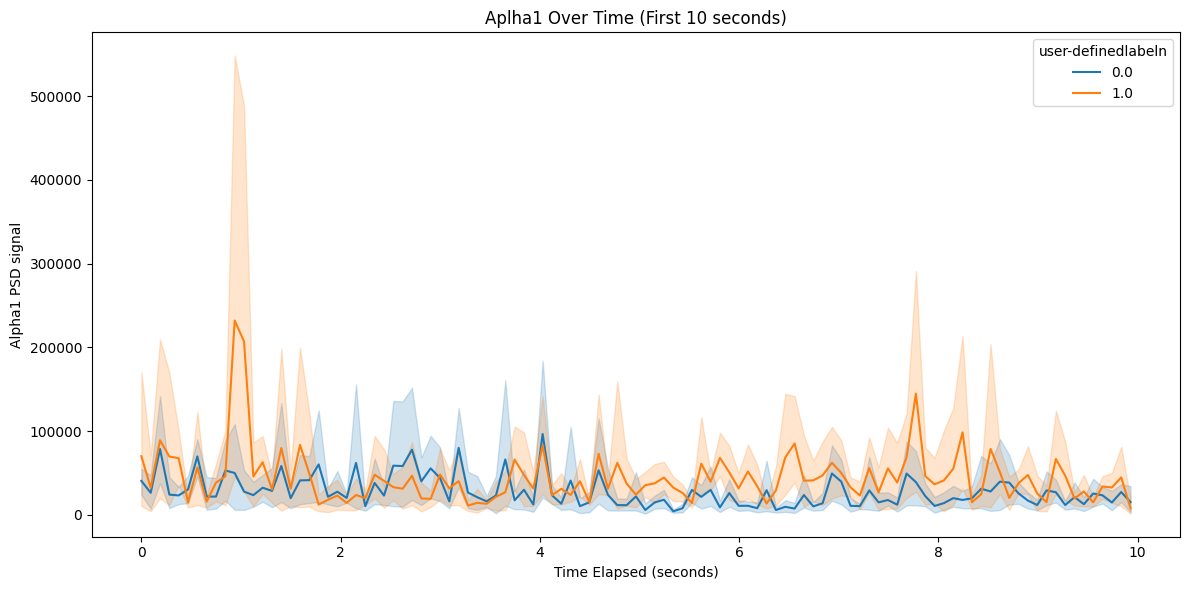

In [16]:
# Select a reasonable slice of time, e.g., first 10 seconds
slice_df = time_df[time_df['seconds_elapsed'] <= 10]

# Plot time vs alpha1, color-coded by label
plt.figure(figsize=(12, 6))
sns.lineplot(data=slice_df, x='seconds_elapsed', y='Alpha1', hue='user-definedlabeln')
plt.title('Aplha1 Over Time (First 10 seconds)')
plt.xlabel('Time Elapsed (seconds)')
plt.ylabel('Alpha1 PSD signal')
plt.legend(title='user-definedlabeln')
plt.tight_layout()
# Remove sci notation from y axis
plt.ticklabel_format(style='plain', axis='y')
plt.show()

goal of interpretation: look for different levels of ALpha1 for different target labels

confused label is when alpha1 is generally more elevated here
<br>non confused label is when alpha1 is lower in values aside from peak at 8 second mark

# Denoising brainwave columns
Plot binned avg brainwave band PSD values

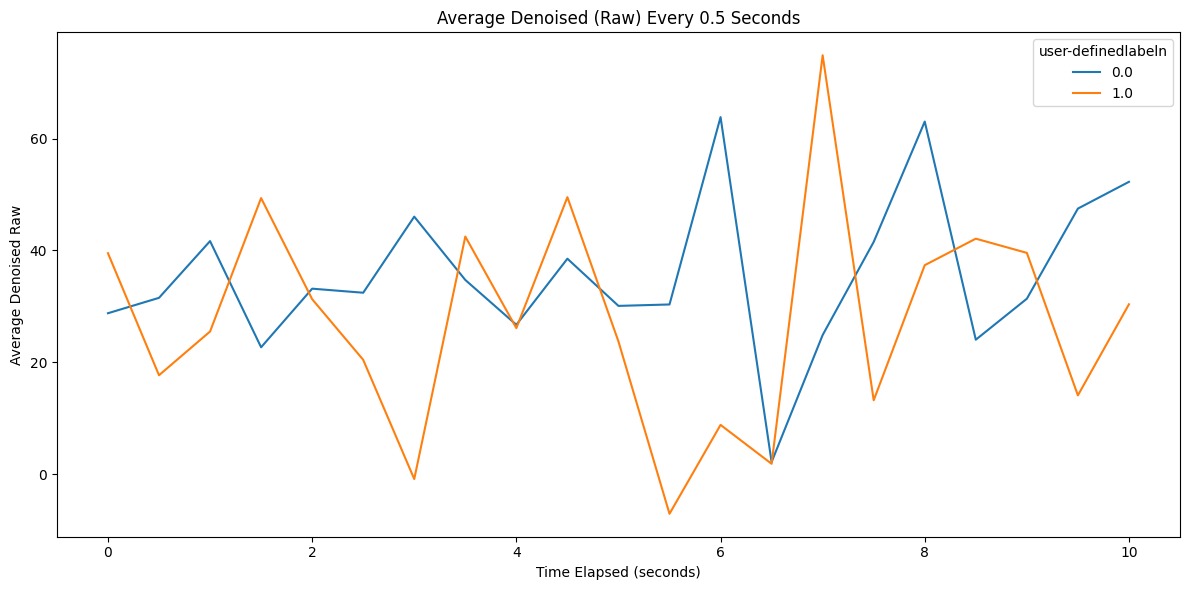

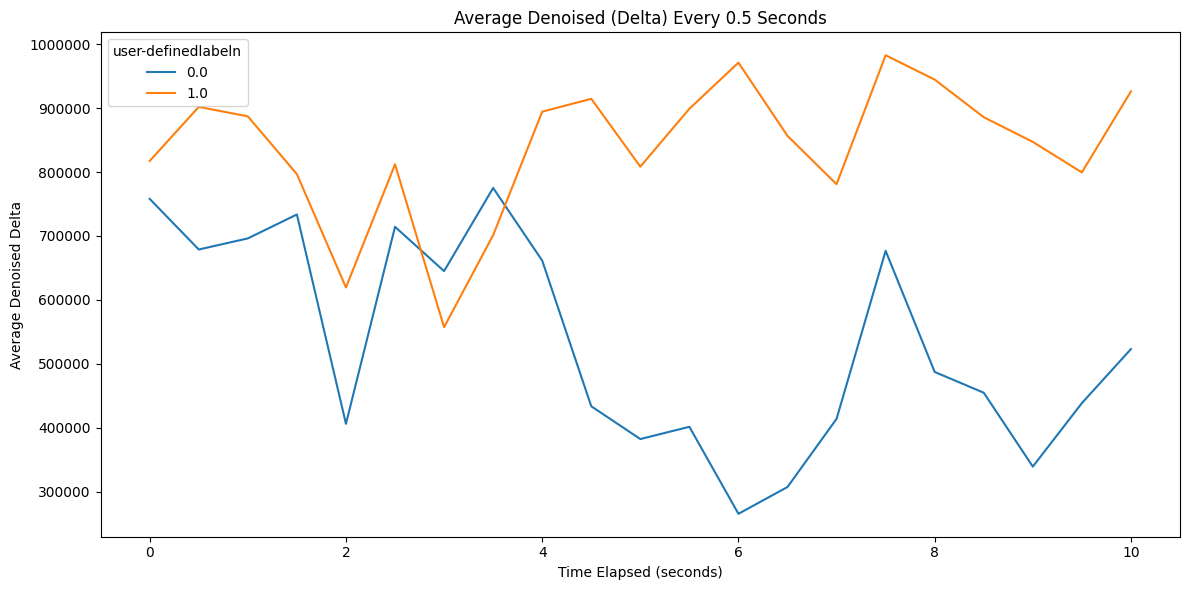

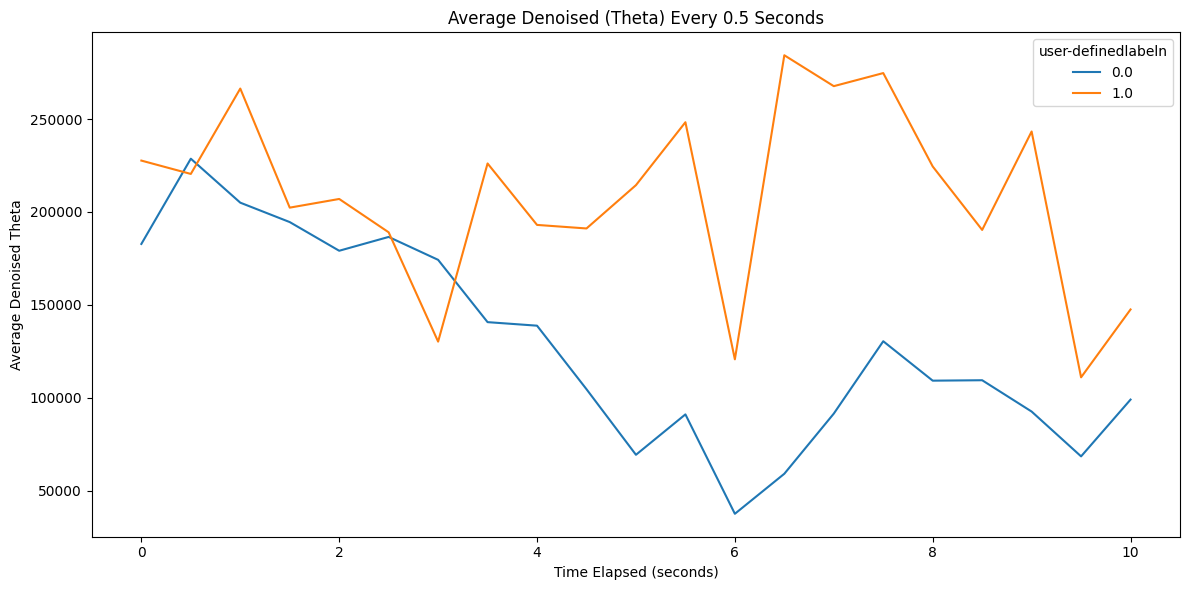

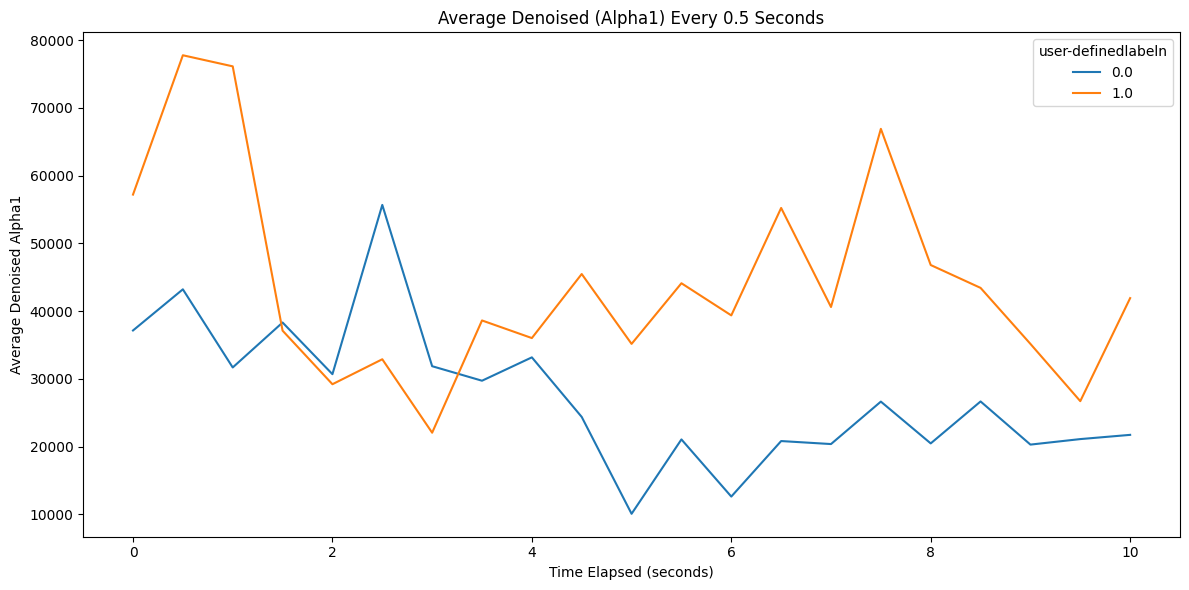

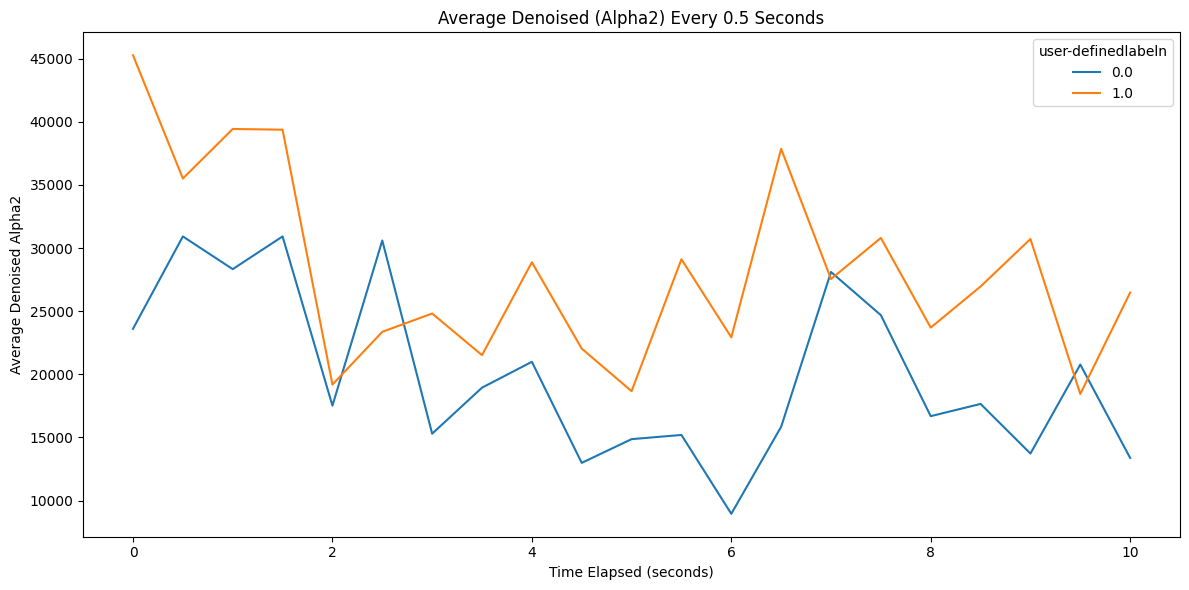

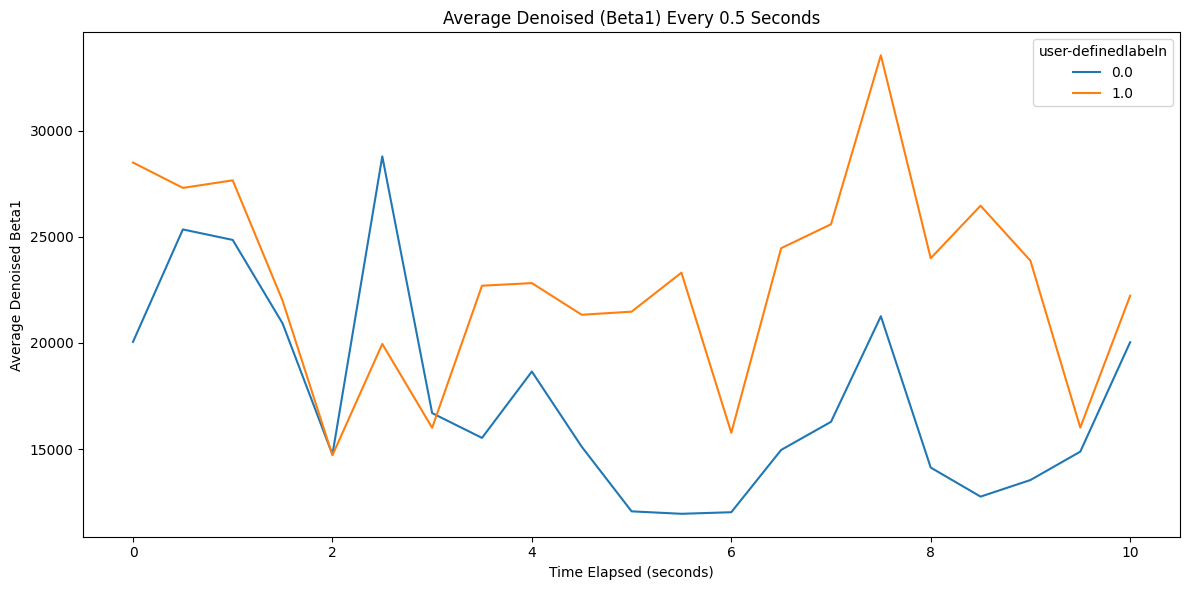

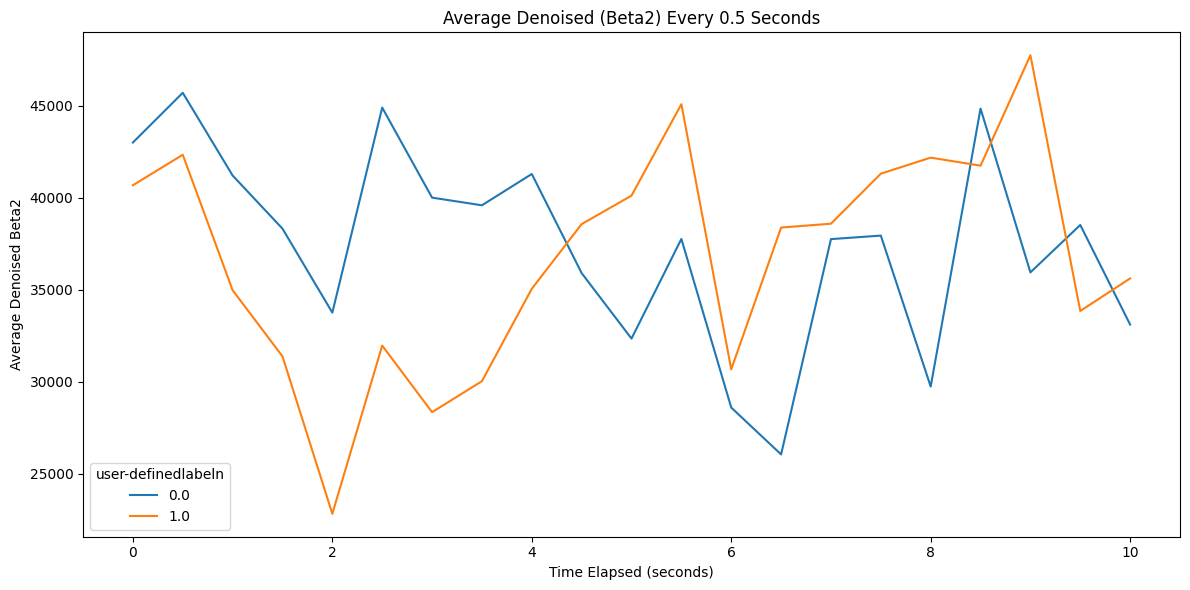

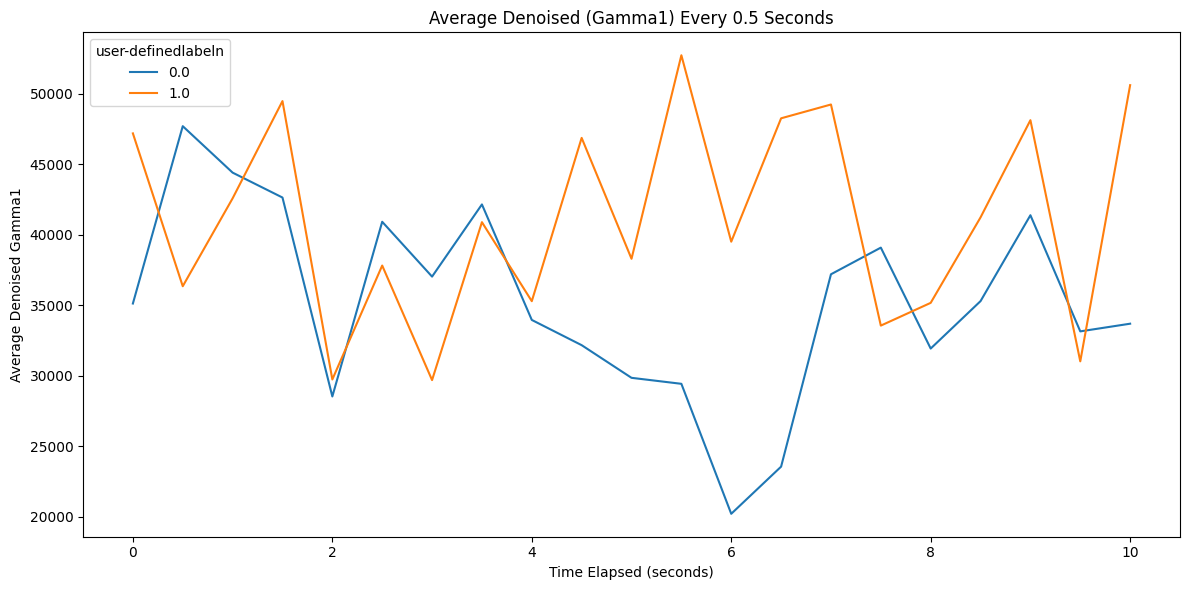

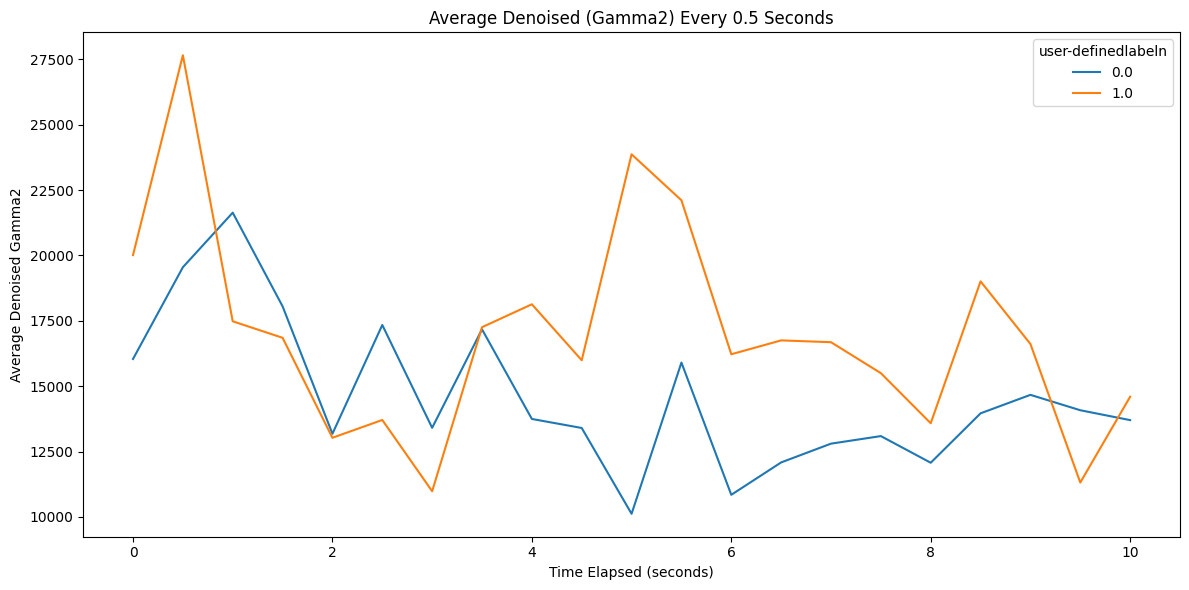

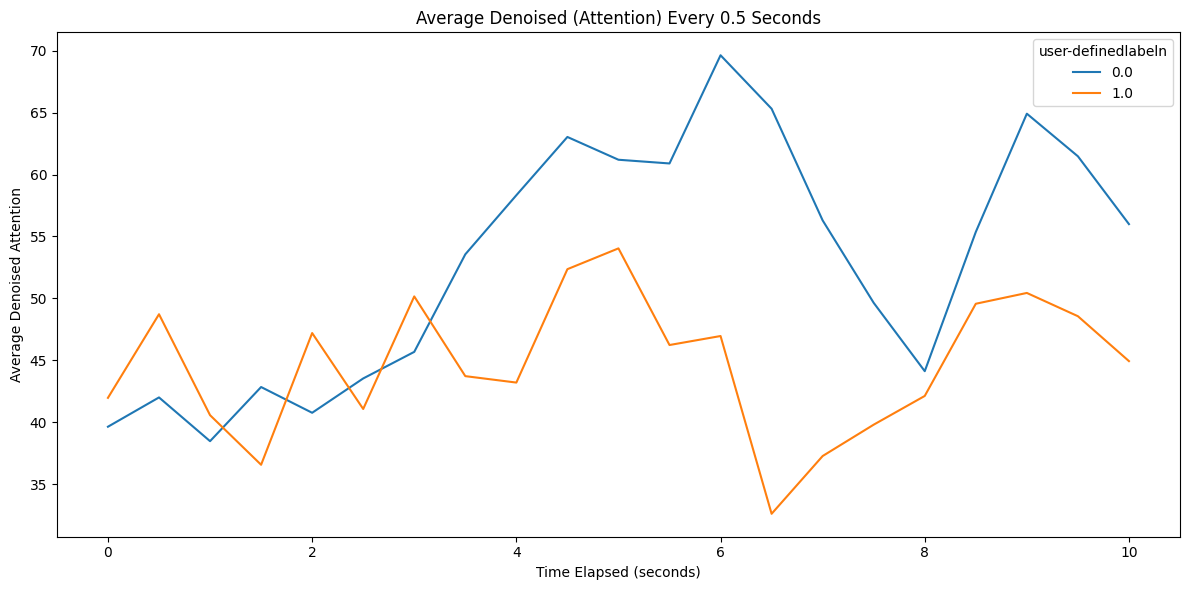

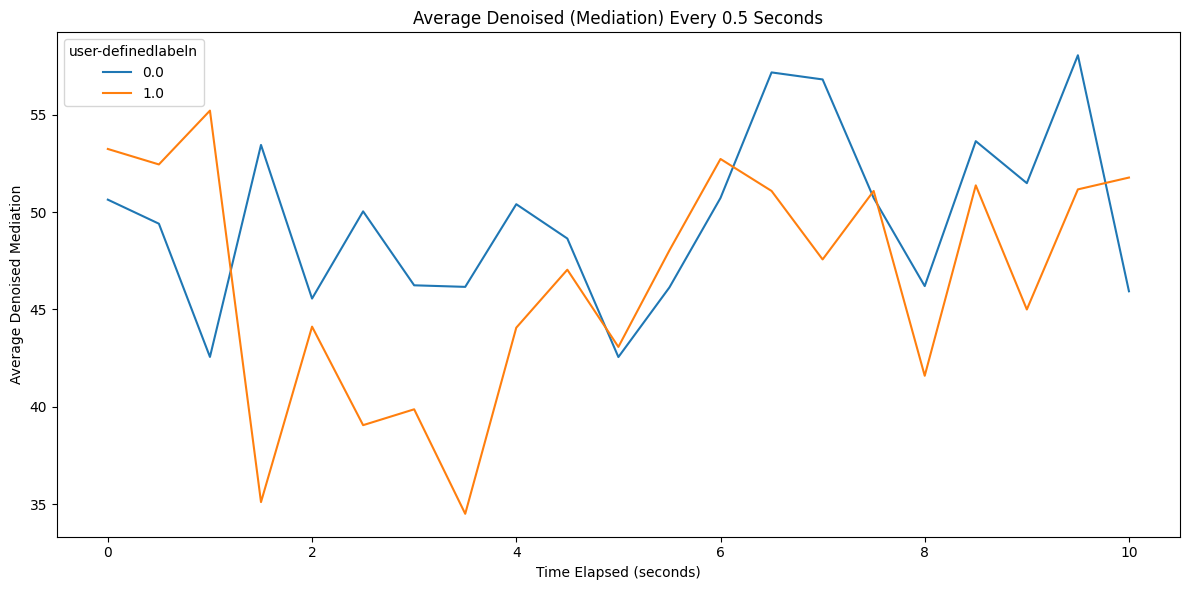

In [46]:
# Create a copy to hold binned data
bin_df = time_df.copy()
# Bin size in seconds
seconds_in_bin = 0.5
# Create time bins
bin_df['time_bin'] = (bin_df['seconds_elapsed'] // seconds_in_bin) * seconds_in_bin

# Define brainwave columns
brainwave_cols = ['Raw','Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2','Attention','Mediation']

# Group by time_bin and label, average all brainwave columns
avg_df = bin_df.groupby(['time_bin', 'user-definedlabeln'], as_index=False)[brainwave_cols].mean()

# Slice for plotting (first 10 seconds only)
slice_df = avg_df[avg_df['time_bin'] <= 10]

# Plot each brainwave denoised
for col in brainwave_cols:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=slice_df, x='time_bin', y=col, hue='user-definedlabeln')
    plt.title(f'Average Denoised ({col}) Every {seconds_in_bin} Seconds')
    plt.xlabel('Time Elapsed (seconds)')
    plt.ylabel(f'Average Denoised {col}')
    plt.legend(title='user-definedlabeln')
    # Remove sci notation from y axis
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.show()

In [47]:
avg_df.head()

time_bin  user-definedlabeln        Raw          Delta          Theta  \
0       0.0                 0.0  28.766667  757999.400000  182793.466667   
1       0.0                 1.0  39.500000  817392.233333  227675.700000   
2       0.5                 0.0  31.520000  678793.960000  228688.760000   
3       0.5                 1.0  17.680000  901936.600000  220486.680000   
4       1.0                 0.0  41.666667  696201.133333  205018.033333   

         Alpha1        Alpha2         Beta1         Beta2        Gamma1  \
0  37136.333333  23608.833333  20052.100000  42993.266667  35134.133333   
1  57189.200000  45275.200000  28508.966667  40671.100000  47203.266667   
2  43208.680000  30923.280000  25355.000000  45694.280000  47714.800000   
3  77749.960000  35511.440000  27313.800000  42328.640000  36360.680000   
4  31676.766667  28332.433333  24859.366667  41201.600000  44419.366667   

         Gamma2  Attention  Mediation  
0  16040.033333  39.633333  50.633333  
1  20013.633333  41.966667  53.233333  
2  19549.520000  42.000000  49.400000  
3  27656.480000  48.720000  52.440000  
4  21637.200000  38.466667  42.566667

Alpha1 PSD values generally higher when confused.

# Visualizations

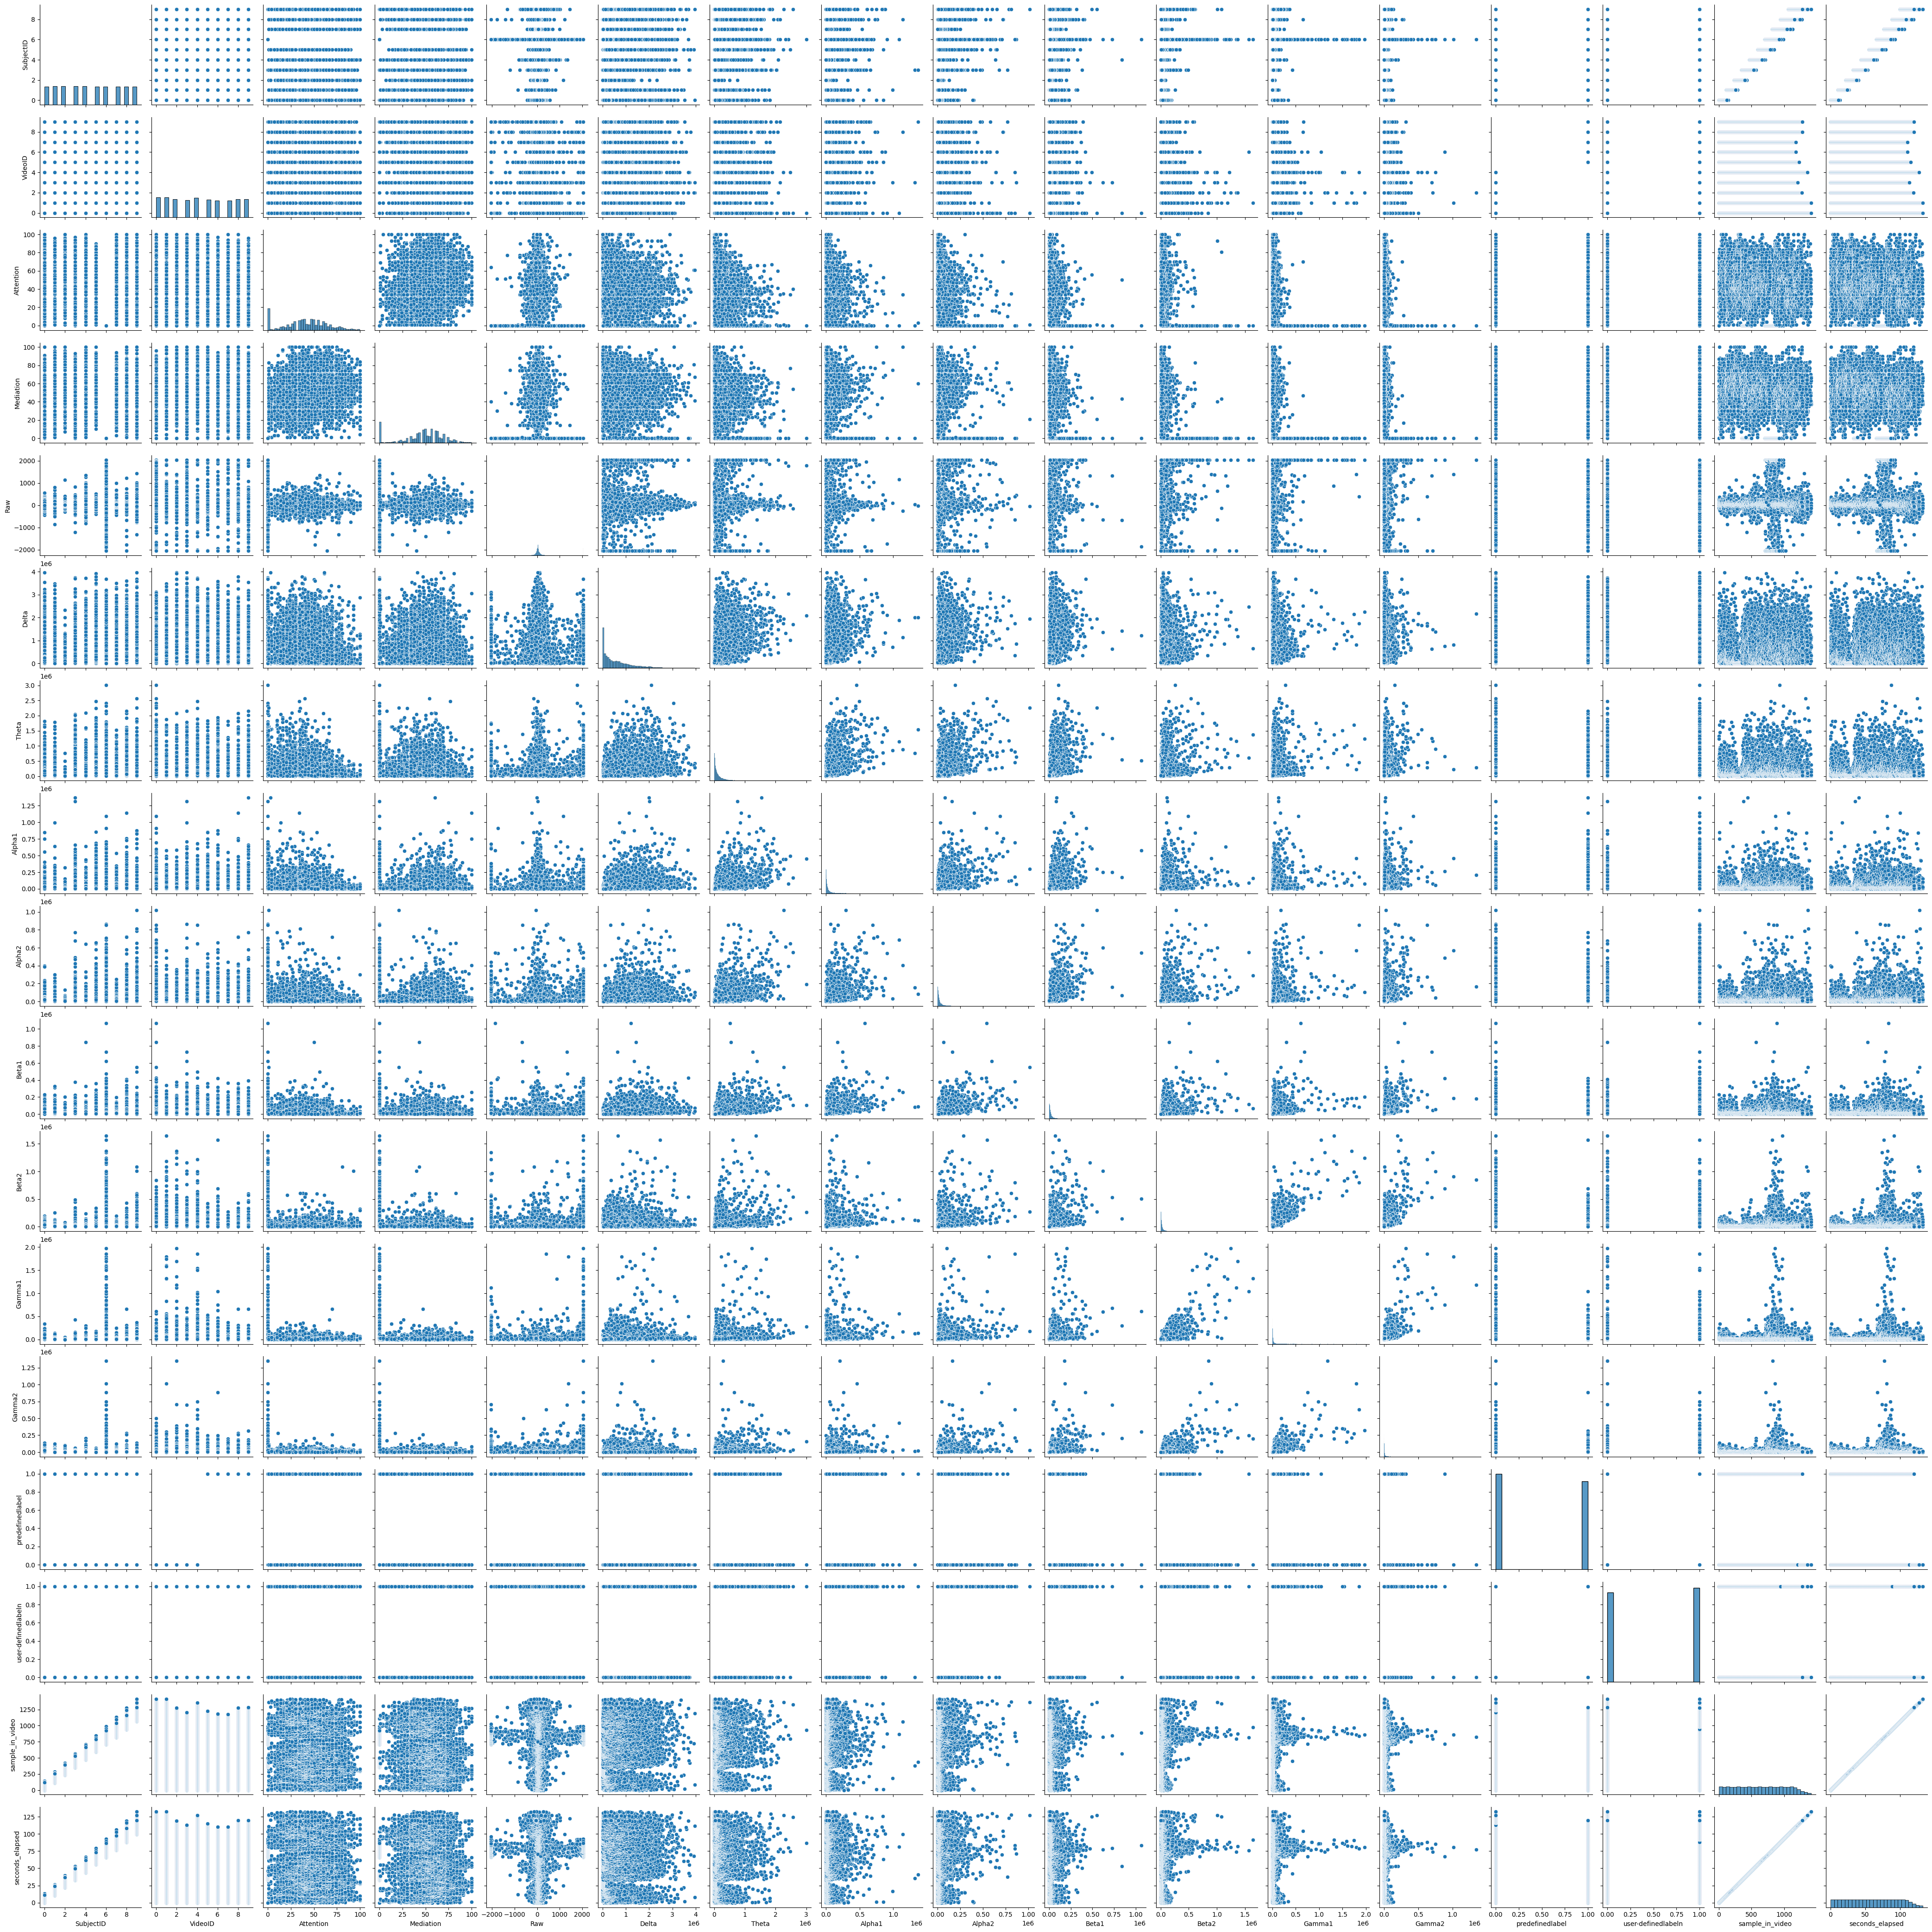

In [25]:
# Pairplot of all variables
sns.pairplot(time_df)

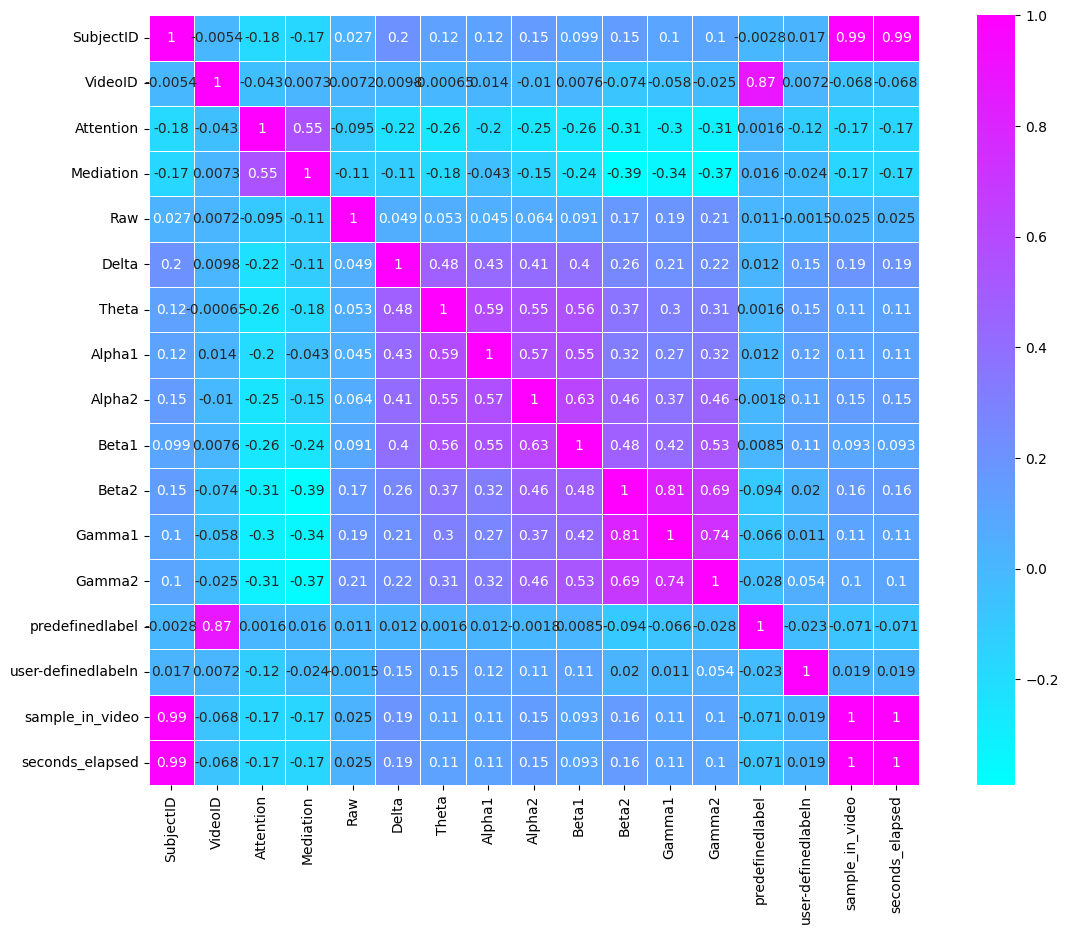

In [26]:
# Correlation matrix
plt.figure(figsize=(15,10)) # Width, height
sns.heatmap(time_df.corr(), annot=True, cmap='cool', linewidths=.5, square=True)
plt.show()

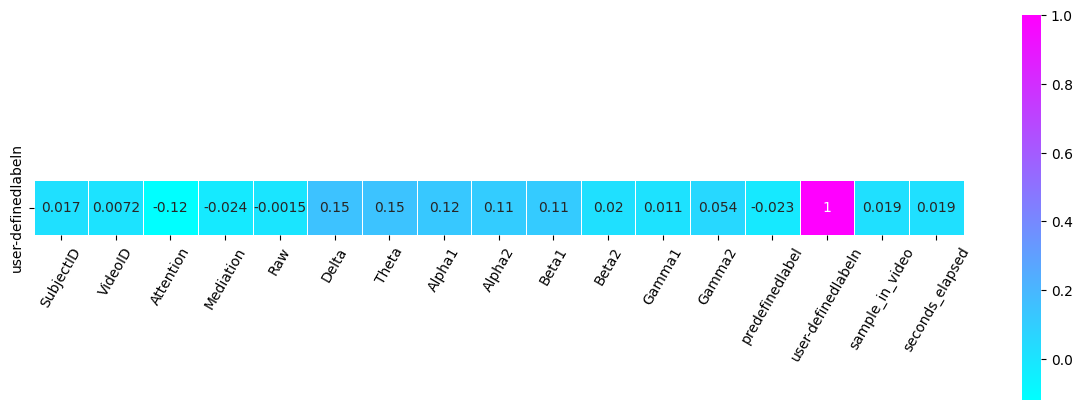

In [27]:
# Correlation matrix of target label
plt.figure(figsize=(15,5)) # Width, height
sns.heatmap(time_df.corr()[['user-definedlabeln']].T, annot=True, cmap='cool', linewidths=.5, square=True)
plt.xticks(rotation=60)
plt.show()

# Denoised df corr

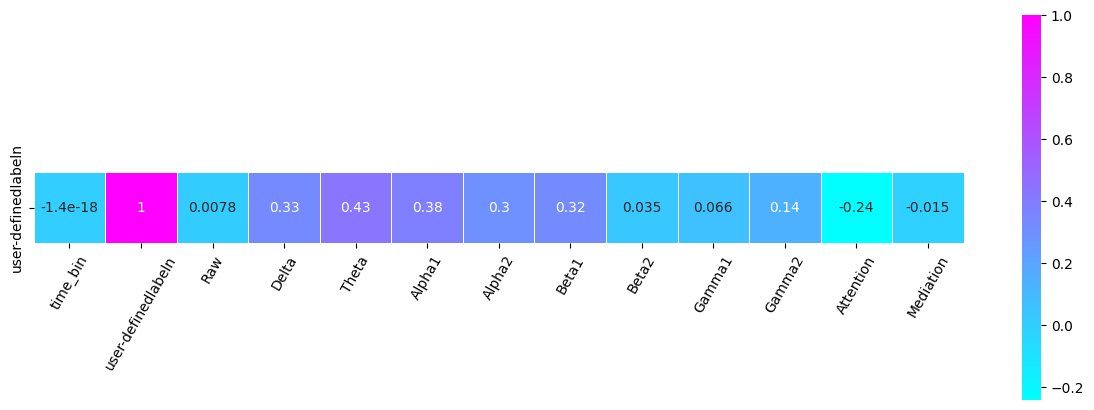

In [48]:
# Correlation matrix of target label
plt.figure(figsize=(15,5)) # Width, height
sns.heatmap(avg_df.corr()[['user-definedlabeln']].T, annot=True, cmap='cool', linewidths=.5, square=True)
plt.xticks(rotation=60)
plt.show()

# Define x and y for training

In [29]:
# Variables
X = raw_df.drop(['user-definedlabeln'], axis=1) # axis 1 = across columns
y = raw_df['user-definedlabeln']

In [30]:
X.head()

SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
0        0.0      0.0       56.0       43.0  278.0   301963.0   90612.0   
1        0.0      0.0       40.0       35.0  -50.0    73787.0   28083.0   
2        0.0      0.0       47.0       48.0  101.0   758353.0  383745.0   
3        0.0      0.0       47.0       57.0   -5.0  2012240.0  129350.0   
4        0.0      0.0       44.0       53.0   -8.0  1005145.0  354328.0   

     Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  predefinedlabel  
0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0              0.0  
1    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0              0.0  
2  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0              0.0  
3   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0              0.0  
4   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0              0.0

# XGBoost Training - no denoising

In [31]:
# Split data into training and validation sets for early stopping (binary classification)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- XGBoost Model Training with Early Stopping (Binary Class) ---

print("--- Starting XGBoost Training with Early Stopping (Binary Class) ---")

model = xgb.XGBClassifier(
    n_estimators=1000,
    objective="binary:logistic",  # Use binary:logistic for binary classification
    eval_metric="logloss",        # Use logloss for binary classification
    random_state=42,
    early_stopping_rounds=50,
)

# Fit the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=20
)

print("\n--- XGBoost Training Completed ---")

# --- 4. Access Best Iteration and Score ---
print(f"Best iteration (number of trees): {model.best_iteration}")
print(f"Best validation score: {model.best_score}")


--- Starting XGBoost Training with Early Stopping (Binary Class) ---
[0]	validation_0-logloss:0.56751
[20]	validation_0-logloss:0.18542
[40]	validation_0-logloss:0.03447
[60]	validation_0-logloss:0.01718
[80]	validation_0-logloss:0.00820
[100]	validation_0-logloss:0.00591
[120]	validation_0-logloss:0.00479
[140]	validation_0-logloss:0.00374
[160]	validation_0-logloss:0.00308
[180]	validation_0-logloss:0.00268
[200]	validation_0-logloss:0.00249
[220]	validation_0-logloss:0.00234
[240]	validation_0-logloss:0.00226
[260]	validation_0-logloss:0.00218
[280]	validation_0-logloss:0.00205
[300]	validation_0-logloss:0.00194
[320]	validation_0-logloss:0.00186
[340]	validation_0-logloss:0.00183
[360]	validation_0-logloss:0.00178
[380]	validation_0-logloss:0.00175
[400]	validation_0-logloss:0.00172
[420]	validation_0-logloss:0.00171
[440]	validation_0-logloss:0.00170
[460]	validation_0-logloss:0.00169
[480]	validation_0-logloss:0.00170
[500]	validation_0-logloss:0.00169
[520]	validation_0-logloss:

In [32]:
# Predict class probabilities
y_val_proba = model.predict_proba(X_val)

# Predict class labels
y_val_pred = model.predict(X_val)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Log loss (multi-class logloss, same as eval_metric)
val_logloss = log_loss(y_val, y_val_proba)
print(f"Validation Log Loss: {val_logloss:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm)

# Detailed classification report (precision, recall, f1-score)
report = classification_report(y_val, y_val_pred, target_names=[str(cls) for cls in model.classes_])
print("\nClassification Report:")
print(report)


Validation Accuracy: 1.0000
Validation Log Loss: 0.0016

Confusion Matrix:
[[1249    0]
 [   0 1314]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1249
           1       1.00      1.00      1.00      1314

    accuracy                           1.00      2563
   macro avg       1.00      1.00      1.00      2563
weighted avg       1.00      1.00      1.00      2563



# Shap value for feature correlation - no denoising

100%|===================| 12799/12811 [08:10<00:00]        

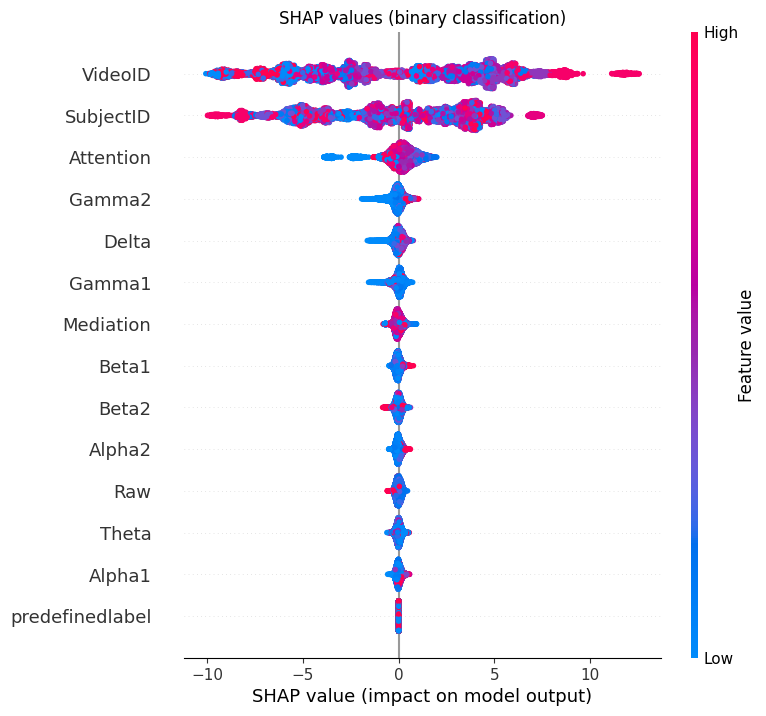

In [34]:
# Explain the model with SHAP
explainer = shap.Explainer(model, X)
# Shap values that explain X positive class
shap_values = explainer(X)
# SHAP values for binary classification - shape: (n_samples, n_features) - one SHAP value per feature, per sample.
shap_values_matrix = shap_values.values 

# SHAP values for each class
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_matrix,
    X.values,
    feature_names=X.columns,
    show=False
)
plt.title("SHAP values (binary classification)")
plt.show()

# Dropping columns 

The VideoID and SubjectID have a very strong influence, but only within small ranges of inputs with poor target value separation. 

These features seem less practical for generalizing to other real world data to predict human emotion based on EEG data. We will re-test SHAP values without these features.

Real world EEG data for this application would also likely not contain the supplied predefined label where the subjects were expected to be confused, so this column will also be removed.

In [39]:
# Remove VideoID and SubjectID
selected_df = raw_df.drop(['VideoID', 'SubjectID','predefinedlabel'], axis = 1)

# Variables
X = selected_df.drop(['user-definedlabeln'], axis=1) # axis 1 = across columns
y = raw_df['user-definedlabeln']

# XGBoost Training - refined features

In [40]:
# Split data into training and validation sets for early stopping (binary classification)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- XGBoost Model Training with Early Stopping (Binary Class) ---

print("--- Starting XGBoost Training with Early Stopping (Binary Class) ---")

model = xgb.XGBClassifier(
    n_estimators=1000,
    objective="binary:logistic",  # Use binary:logistic for binary classification
    eval_metric="logloss",        # Use logloss for binary classification
    random_state=42,
    early_stopping_rounds=50,
)

# Fit the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=20
)

print("\n--- XGBoost Training Completed ---")

# --- 4. Access Best Iteration and Score ---
print(f"Best iteration (number of trees): {model.best_iteration}")
print(f"Best validation score: {model.best_score}")


--- Starting XGBoost Training with Early Stopping (Binary Class) ---
[0]	validation_0-logloss:0.67119
[20]	validation_0-logloss:0.62775
[40]	validation_0-logloss:0.63374
[60]	validation_0-logloss:0.63960
[64]	validation_0-logloss:0.64094

--- XGBoost Training Completed ---
Best iteration (number of trees): 15
Best validation score: 0.6262586843723833


In [41]:
# Predict class probabilities
y_val_proba = model.predict_proba(X_val)

# Predict class labels
y_val_pred = model.predict(X_val)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Log loss (multi-class logloss, same as eval_metric)
val_logloss = log_loss(y_val, y_val_proba)
print(f"Validation Log Loss: {val_logloss:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm)

# Detailed classification report (precision, recall, f1-score)
report = classification_report(y_val, y_val_pred, target_names=[str(cls) for cls in model.classes_])
print("\nClassification Report:")
print(report)


Validation Accuracy: 0.6547
Validation Log Loss: 0.6263

Confusion Matrix:
[[782 467]
 [418 896]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1249
           1       0.66      0.68      0.67      1314

    accuracy                           0.65      2563
   macro avg       0.65      0.65      0.65      2563
weighted avg       0.65      0.65      0.65      2563



# Shap value for refined features - no denoising

In [42]:
print(shap_values.values.shape)

(12811, 14)


 96%|=================== | 12285/12811 [00:17<00:00]       

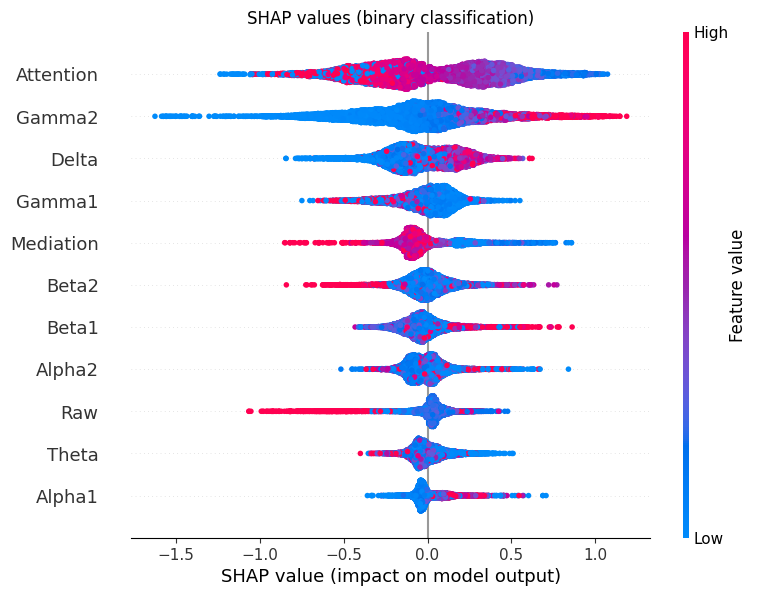

In [43]:
# Explain the model with SHAP
explainer = shap.Explainer(model, X)
# Shap values that explain X positive class
shap_values = explainer(X)
# SHAP values for binary classification - shape: (n_samples, n_features) - one SHAP value per feature, per sample.
shap_values_matrix = shap_values.values 

# SHAP values for each class
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_matrix,
    X.values,
    feature_names=X.columns,
    show=False
)
plt.title("SHAP values (binary classification)")
plt.show()

# We'll now remove little to no correlation vales and no to little significant SHAP values,
# as well as use the denoised data, for a refined XGBoost model


# XGBoost Training and Shap value for feature correlation 
# (with denoising)

In [ ]:
avg_df.head()

In [55]:
# Variables
X = avg_df.drop(['user-definedlabeln', 'time_bin'], axis=1) # axis 1 = across columns
y = avg_df['user-definedlabeln']


In [56]:
X.head()

Raw          Delta          Theta        Alpha1        Alpha2  \
0  28.766667  757999.400000  182793.466667  37136.333333  23608.833333   
1  39.500000  817392.233333  227675.700000  57189.200000  45275.200000   
2  31.520000  678793.960000  228688.760000  43208.680000  30923.280000   
3  17.680000  901936.600000  220486.680000  77749.960000  35511.440000   
4  41.666667  696201.133333  205018.033333  31676.766667  28332.433333   

          Beta1         Beta2        Gamma1        Gamma2  Attention  \
0  20052.100000  42993.266667  35134.133333  16040.033333  39.633333   
1  28508.966667  40671.100000  47203.266667  20013.633333  41.966667   
2  25355.000000  45694.280000  47714.800000  19549.520000  42.000000   
3  27313.800000  42328.640000  36360.680000  27656.480000  48.720000   
4  24859.366667  41201.600000  44419.366667  21637.200000  38.466667   

   Mediation  
0  50.633333  
1  53.233333  
2  49.400000  
3  52.440000  
4  42.566667

In [57]:
# Split data into training and validation sets for early stopping (binary classification)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- XGBoost Model Training with Early Stopping (Binary Class) ---

print("--- Starting XGBoost Training with Early Stopping (Binary Class) ---")

model = xgb.XGBClassifier(
    n_estimators=1000,
    objective="binary:logistic",  # Use binary:logistic for binary classification
    eval_metric="logloss",        # Use logloss for binary classification
    random_state=42,
    early_stopping_rounds=50,
)

# Fit the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=20
)

print("\n--- XGBoost Training Completed ---")

# --- 4. Access Best Iteration and Score ---
print(f"Best iteration (number of trees): {model.best_iteration}")
print(f"Best validation score: {model.best_score}")


--- Starting XGBoost Training with Early Stopping (Binary Class) ---
[0]	validation_0-logloss:0.60079
[20]	validation_0-logloss:0.49842
[40]	validation_0-logloss:0.55259
[60]	validation_0-logloss:0.58346
[63]	validation_0-logloss:0.58100

--- XGBoost Training Completed ---
Best iteration (number of trees): 14
Best validation score: 0.4739835851579764


In [59]:
# Predict class probabilities
y_val_proba = model.predict_proba(X_val)

# Predict class labels
y_val_pred = model.predict(X_val)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Log loss (multi-class logloss, same as eval_metric)
val_logloss = log_loss(y_val, y_val_proba)
print(f"Validation Log Loss: {val_logloss:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm)

# Detailed classification report (precision, recall, f1-score)
report = classification_report(y_val, y_val_pred, target_names=[str(cls) for cls in model.classes_])
print("\nClassification Report:")
print(report)


Validation Accuracy: 0.7830
Validation Log Loss: 0.4740

Confusion Matrix:
[[43 10]
 [13 40]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        53
           1       0.80      0.75      0.78        53

    accuracy                           0.78       106
   macro avg       0.78      0.78      0.78       106
weighted avg       0.78      0.78      0.78       106



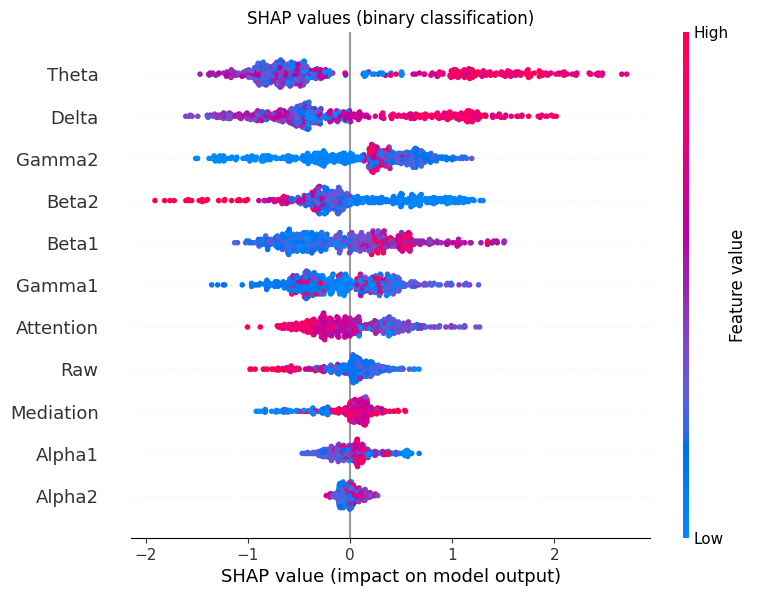

In [61]:
# Explain the model with SHAP
explainer = shap.Explainer(model, X)
# Shap values that explain X positive class
shap_values = explainer(X)
# SHAP values for binary classification - shape: (n_samples, n_features) - one SHAP value per feature, per sample.
shap_values_matrix = shap_values.values 

# SHAP values for each class
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_matrix,
    X.values,
    feature_names=X.columns,
    show=False
)
plt.title("SHAP values (binary classification)")
plt.show()